In [1]:
import librosa

PATH = "./song.mp3"

SAMPLE_RATE = 11025      # Sample rate for audio files (~11 kHz)

def load_song(file_path, sample_rate=SAMPLE_RATE):
    song, sr = librosa.load(file_path, sr=sample_rate, mono=True)
    return song, sr

song, sample_rate = load_song(PATH)
print(f"Song shape: {song.shape} samples")
print(f"Sample rate: {sample_rate} Hz")

Song shape: (3100320,) samples
Sample rate: 11025 Hz


In [2]:
WINDOW_SIZE = 1024
OVERLAP = 0.5

def frame_audio(audio, window_size=WINDOW_SIZE, overlap=OVERLAP):
    hop_length = int(window_size * (1 - overlap))
    frames = librosa.util.frame(audio, frame_length=window_size, hop_length=hop_length).T
    return frames

frames = frame_audio(song)
print(f"Number of frames: {frames.shape[0]}")
print(f"Frame size: {frames.shape[1]} samples")

Number of frames: 6054
Frame size: 1024 samples


A **Hanning (or Hann) window** is a smooth, bell-shaped function used in digital signal processing to reduce spectral leakage when analyzing signals, especially during Fourier Transforms (FFT). It works by gradually tapering signal data to zero at its edges, preventing abrupt discontinuities that cause energy from "leaking" into adjacent frequency bins, thereby improving the accuracy of frequency analysis, though with some trade-off in frequency resolution.

![Hanning Window](https://community.sw.siemens.com/servlet/rtaImage?eid=ka6KZ00000000iw&feoid=00N4O000006Yxpf&refid=0EM4O00000113sm)

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt

def compute_stft(signal, n_fft=WINDOW_SIZE, hop_length=int(WINDOW_SIZE*(1 - OVERLAP))):
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window="hann", center=False)
    return stft

stft = compute_stft(song)
print(f"STFT shape: {stft.shape}")

STFT shape: (513, 6054)


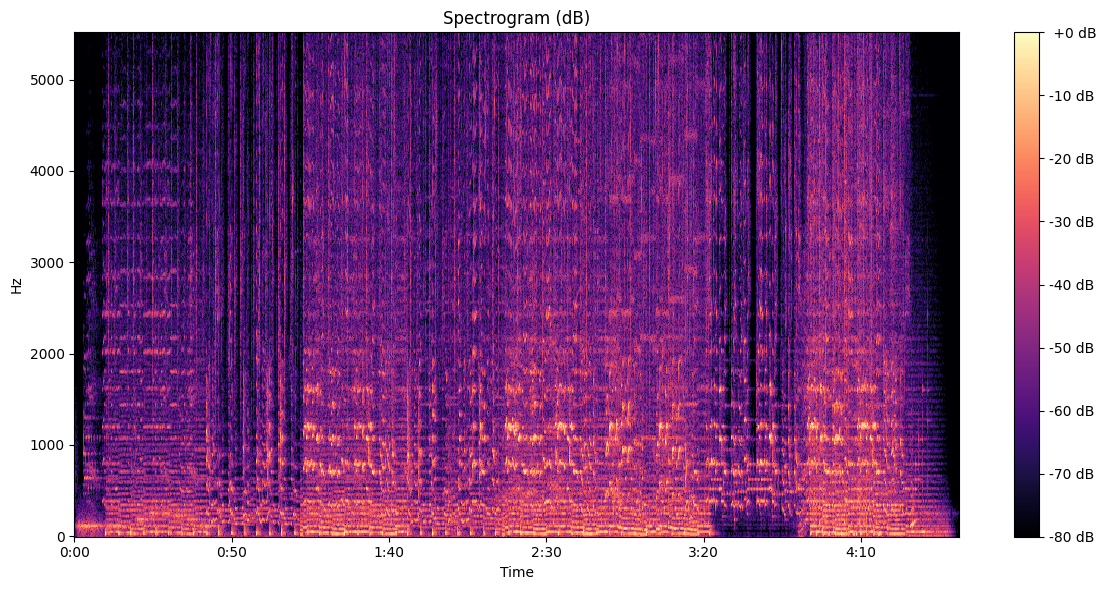

Spectrogram shape: (463, 6054)


In [4]:
def plot_spectrogram(stft, sample_rate=SAMPLE_RATE, n_fft=WINDOW_SIZE):
    magnitude = np.abs(stft)
    db = librosa.amplitude_to_db(magnitude, ref=np.max)

    freqs = librosa.fft_frequencies(sr=sample_rate, n_fft=n_fft)
    
    # Filter frequencies between 20 Hz and 5 kHz
    mask = (freqs >= 20) & (freqs <= 5000)      
    db = db[mask, :]
    
    plt.figure(figsize=(12, 6))
    librosa.display.specshow(db, sr=sample_rate, x_axis="time", y_axis="linear", cmap="magma")
    plt.colorbar(format="%+3.0f dB")
    plt.title("Spectrogram (dB)")
    plt.tight_layout()
    plt.show()

    return db

I = plot_spectrogram(stft)
print(f"Spectrogram shape: {I.shape}")